In [1]:
import os
import warnings
import math
import csv
import pathlib
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path, PureWindowsPath

# Suppress warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow')
warnings.filterwarnings('ignore', category=DeprecationWarning, module='tensorflow')

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier

# TensorFlow & Keras
import tensorflow as tf
from keras import models, layers
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import layers

# Disable oneDNN optimizations
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Enable inline plotting
%matplotlib inline

# 1. Loading the Data

- We are loading the dataset from a CSV file into a Pandas DataFrame.  
- Then, we are printing the shape of the dataset to check the number of rows and columns. 
- After that, we are displaying the first few rows to get an overview of the dataset. 
- Finally, we are generating summary statistics to understand the distribution of numerical columns, including mean, standard deviation, min, max, and percentiles.

In [2]:
Final_df = pd.read_csv('./dataset/features_3_sec.csv')
print(Final_df.shape)  # Print dataset dimensions

(9990, 60)


In [3]:
Final_df.head() # Show first few rows

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [4]:
Final_df.describe()  # Display summary statistics

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
count,9990.0,9990.000000,9990.000000,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,9.990000e+03,9990.000000,...,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000,9990.000000
mean,66149.0,0.379534,0.084876,0.130859,2.676388e-03,2199.219431,4.166727e+05,2241.385959,1.182711e+05,4566.076592,...,1.448240,49.988755,-4.198706,51.962753,0.739943,52.488851,-2.497306,54.973829,-0.917584,57.322614
std,0.0,0.090466,0.009637,0.068545,3.585628e-03,751.860611,4.349644e+05,543.854449,1.013505e+05,1642.065335,...,5.735149,34.442816,5.677379,36.400669,5.181313,38.177120,5.111799,41.585677,5.253243,46.444212
min,66149.0,0.107108,0.015345,0.000953,4.379535e-08,472.741636,8.118813e+02,499.162910,1.183520e+03,658.336276,...,-26.850016,1.325786,-27.809795,1.624544,-20.733809,3.437439,-27.448456,3.065302,-35.640659,0.282131
25%,66149.0,0.315698,0.079833,0.083782,6.145900e-04,1630.680158,1.231961e+05,1887.455790,4.876553e+04,3378.311110,...,-2.227478,29.584894,-7.951722,29.863448,-2.516638,29.636197,-5.734123,30.496412,-4.004475,30.011365
50%,66149.0,0.384741,0.085108,0.121253,1.491318e-03,2208.628236,2.650692e+05,2230.575595,8.996072e+04,4631.377892,...,1.461623,41.702393,-4.443021,42.393583,0.733772,41.831377,-2.702366,43.435253,-1.030939,44.332155
75%,66149.0,0.442443,0.091092,0.176328,3.130862e-03,2712.581884,5.624152e+05,2588.340505,1.585674e+05,5591.634521,...,5.149752,59.274619,-0.726945,61.676964,3.888734,62.033906,0.514246,65.328602,2.216603,68.210421
max,66149.0,0.749481,0.120964,0.442567,3.261522e-02,5432.534406,4.794119e+06,3708.147554,1.235143e+06,9487.446477,...,39.144405,683.932556,34.048843,529.363342,36.970322,629.729797,31.365425,1143.230591,34.212101,910.473206


# 2. First Model Training

### 2.1 Splitting the data into Train and Test data

Data Preprocessing and Feature Engineering:

- Feature extraction and target selection: We identify the feature columns (excluding non-feature columns like filenames) and define the target variable y1 (genre labels).
- Feature scaling: The features are normalized using StandardScaler to improve the model's performance and speed up convergence.
- Label encoding: Convert the target labels from categorical to numerical values for model compatibility.
- Train-test split: The dataset is divided into training and testing subsets with an 80-20 split to train and evaluate the model performance.

In [5]:
# Extract relevant features and target variable
# - We remove non-feature columns (such as 'filename', 'label', 'length') and select the remaining columns as the features
X1 = Final_df.loc[:, ~Final_df.columns.isin(['filename', 'label', 'length'])]  # Remove non-feature columns

# - The 'label' column is selected as the target variable
y1 = Final_df['label']  # Target variable

# Normalize features
# - Standardize the feature data (X1) to have mean=0 and variance=1 for better model convergence
scaler = StandardScaler()
X1 = scaler.fit_transform(X1)

# Encode labels
# - Convert the categorical target labels into numerical labels using LabelEncoder
encoder = LabelEncoder()
y1 = encoder.fit_transform(y1)

# Split the data into training and testing sets (80-20 split)
# - The training data will be 80% and the testing data will be 20% of the original data
# - We shuffle the data and set a random seed for reproducibility
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, shuffle=True, random_state=42)


### 2.2 Checking if Training Data is Balanced

Class Distribution Analysis:

- Genre labels: We define the genre labels (categories) corresponding to the target variable.
- Class counts: Count the instances for each genre in both the training and testing sets to ensure balanced classes.
- Visualization: The distribution of genres in the training and testing sets is plotted to visually inspect the class balance.

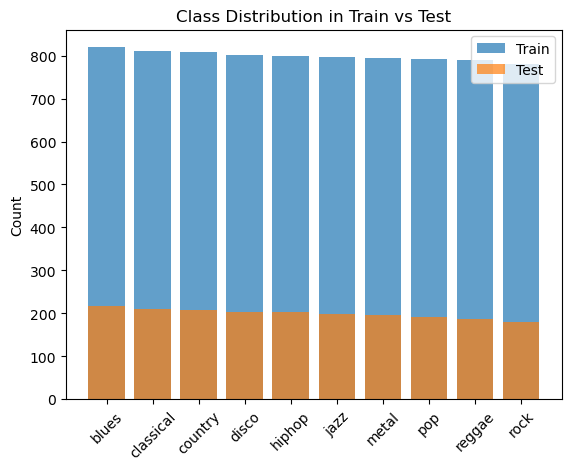

In [6]:
# Define genre labels
# - We define the list of genre labels that correspond to the target variable classes
genres = ["blues", "classical", "country", "disco", "hiphop", 
          "jazz", "metal", "pop", "reggae", "rock"]

# Count instances per class in the training set
# - This helps us understand the class distribution in the training data
train_class_counts = pd.Series(y1_train).value_counts()

# Count instances per class in the testing set
# - This helps us understand the class distribution in the testing data
test_class_counts = pd.Series(y1_test).value_counts()

# Plot class distribution
# - Visualize the class distribution in both the training and testing sets to ensure the split is balanced
plt.bar(genres, train_class_counts, label="Train", alpha=0.7)
plt.bar(genres, test_class_counts, label="Test", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Class Distribution in Train vs Test")
plt.legend()
plt.show()

### 2.3 Model Training

Model Architecture and Training:

- Model architecture: We define a deep neural network model with several dense layers (input, hidden, and output layers). The layers use ReLU activation with L2 regularization and batch normalization for stable learning.
- Model compilation: The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the evaluation metric.
- Model training: We train the model for 20 epochs with a batch size of 16, using both training and validation data to monitor the model’s learning progress.

In [7]:
# Define the model architecture using Keras
# - The model consists of an input layer, several hidden layers, and an output layer

Model1 = models.Sequential([
    # Input layer
    # - First dense layer with ReLU activation and L2 regularization
    keras.layers.Dense(1024, activation='relu', input_shape=(X1_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),  # Normalize activations for stable learning
    
    # Hidden layers
    # - Second dense layer with ReLU activation and L2 regularization
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),  # Normalize activations for stable learning
    
    # - Third dense layer with ReLU activation and L2 regularization
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),  # Normalize activations for stable learning
    
    # Output layer
    # - A final dense layer with softmax activation to output probabilities for each class (10 classes)
    keras.layers.Dense(10, activation='softmax')  # Output 10 possible classes (genres)
])

# Compile the model
# - Using the Adam optimizer with a low learning rate for stable learning
# - Sparse categorical cross-entropy loss function for multi-class classification
# - Metrics include accuracy to evaluate performance

optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)

Model1.compile(optimizer = optimiser,
              loss = tf.keras.losses.sparse_categorical_crossentropy,
              metrics = ['accuracy'])

# Train the model
# - We train the model for 20 epochs with a batch size of 16
# - Use validation data for each epoch to track model performance on the unseen test set

History1 = Model1.fit(X1_train, y1_train,
                      validation_data = (X1_test, y1_test),
                      epochs = 20,
                      batch_size = 16,
                      verbose = 1)


Epoch 1/20


500/500 [==============================] - 6s 7ms/step - loss: 1.3190 - accuracy: 0.5965 - val_loss: 0.8426 - val_accuracy: 0.7663
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.8182 - accuracy: 0.7585 - val_loss: 0.6900 - val_accuracy: 0.8143
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.6427 - accuracy: 0.8295 - val_loss: 0.5818 - val_accuracy: 0.8504
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.5329 - accuracy: 0.8650 - val_loss: 0.5587 - val_accuracy: 0.8609
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.4625 - accuracy: 0.8929 - val_loss: 0.5009 - val_accuracy: 0.8859
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.3962 - accuracy: 0.9123 - val_loss: 0.4828 - val_accuracy: 0.8794
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: 0.3623 - accuracy: 0.9235 - val_loss: 0.4823 - val_accuracy: 0.8824
Epo

# 3. Second Model Training

### 3.1 Feature selection

- We first preprocesses the dataset by encoding the target column.
- Then we train a RandomForest model to determine feature importance.
- The feature importance scores are stored and displayed in a DataFrame.
- A visualization of feature importance is created using a bar plot.
- Features with importance above the defined threshold (0.01) are selected and displayed.
- The selected features are converted into a list for further use.

In [8]:
# Define the target column
target_column = 'label'


# Drop unnecessary columns if unnecessary
Final_df = Final_df.iloc[:, 1:]


# Encode the target column (convert categorical labels into numerical values)
encoder = LabelEncoder()
Final_df[target_column] = encoder.fit_transform(Final_df[target_column])


# Split data into features (X) and target variable (y)
X = Final_df.drop(columns=[target_column])  # Features
y = Final_df[target_column]  # Target variable


# Train a RandomForest model for feature importance analysis
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)


# Get feature importance values and store them in a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)  # Sorting by importance in descending order


# Display feature importance values
print("Feature Importance:")
feature_importance_df  # Display DataFrame

Feature Importance:


,Feature,Importance
16,perceptr_var,0.050377
4,rms_var,0.036651
3,rms_mean,0.034169
1,chroma_stft_mean,0.032836
24,mfcc4_mean,0.031729
7,spectral_bandwidth_mean,0.029494
9,rolloff_mean,0.027942
18,mfcc1_mean,0.026694
14,harmony_var,0.026464
15,perceptr_mean,0.026119


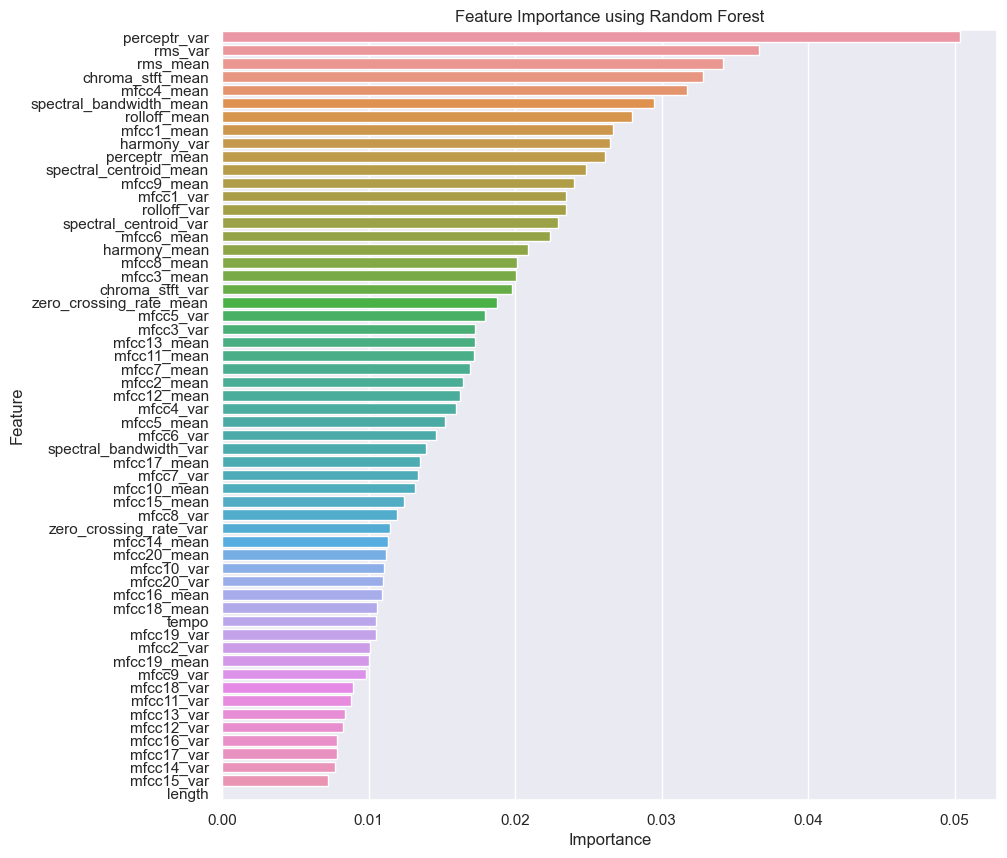

In [9]:
# Visualizing feature importance using Seaborn

plt.figure(figsize=(10, 10))  # Set figure size
sns.set(font_scale=1)  # Set font scale for better readability
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)  # Create bar plot
plt.title("Feature Importance using Random Forest")  # Set title
plt.show()  # Display the plot

In [10]:
# Select important features based on a defined threshold
threshold = 0.01  # Set the importance threshold

# Filtering features with importance greater than or equal to the threshold
selected_features_df = feature_importance_df[feature_importance_df['Importance'] >= threshold]

# Display the selected features and their importance values
print("Selected Features and Their Importance:")

selected_features_df  # Display DataFrame of selected features

Selected Features and Their Importance:


,Feature,Importance
16,perceptr_var,0.050377
4,rms_var,0.036651
3,rms_mean,0.034169
1,chroma_stft_mean,0.032836
24,mfcc4_mean,0.031729
7,spectral_bandwidth_mean,0.029494
9,rolloff_mean,0.027942
18,mfcc1_mean,0.026694
14,harmony_var,0.026464
15,perceptr_mean,0.026119


In [11]:
# Convert selected features into a list
selected_features = list(selected_features_df['Feature'])  

selected_features  # Display the list of selected features

['perceptr_var',
 'rms_var',
 'rms_mean',
 'chroma_stft_mean',
 'mfcc4_mean',
 'spectral_bandwidth_mean',
 'rolloff_mean',
 'mfcc1_mean',
 'harmony_var',
 'perceptr_mean',
 'spectral_centroid_mean',
 'mfcc9_mean',
 'mfcc1_var',
 'rolloff_var',
 'spectral_centroid_var',
 'mfcc6_mean',
 'harmony_mean',
 'mfcc8_mean',
 'mfcc3_mean',
 'chroma_stft_var',
 'zero_crossing_rate_mean',
 'mfcc5_var',
 'mfcc3_var',
 'mfcc13_mean',
 'mfcc11_mean',
 'mfcc7_mean',
 'mfcc2_mean',
 'mfcc12_mean',
 'mfcc4_var',
 'mfcc5_mean',
 'mfcc6_var',
 'spectral_bandwidth_var',
 'mfcc17_mean',
 'mfcc7_var',
 'mfcc10_mean',
 'mfcc15_mean',
 'mfcc8_var',
 'zero_crossing_rate_var',
 'mfcc14_mean',
 'mfcc20_mean',
 'mfcc10_var',
 'mfcc20_var',
 'mfcc16_mean',
 'mfcc18_mean',
 'tempo',
 'mfcc19_var',
 'mfcc2_var',
 'mfcc19_mean']

### 3.2 Splitting the data into Train and Test data

- We first select important features from `Final_df`.
- Then, we normalize the features using `StandardScaler()` for better model performance.
- The target labels are encoded into numeric form using `LabelEncoder()`.
- Finally, we split the dataset into training and testing sets to prepare for model training.

In [12]:
# Select only the important features based on the threshold
X2 = Final_df[selected_features]  # Keeping only selected features

# Define the target variable
y2 = Final_df['label']  

# Normalize features to have mean = 0 and standard deviation = 1 (important for models sensitive to scale)
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)  # Standardizing the feature values

# Encode labels into numerical format (useful for classification models)
encoder = LabelEncoder()
y2 = encoder.fit_transform(y2)  # Converting categorical labels into numeric form

# Split data into training and testing sets (80% training, 20% testing)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, shuffle=True, random_state=42)

### 3.3 Checking if Training Data is Balanced

Class Distribution Analysis:

- Genre labels: We define the genre labels (categories) corresponding to the target variable.
- Class counts: Count the instances for each genre in both the training and testing sets to ensure balanced classes.
- Visualization: The distribution of genres in the training and testing sets is plotted to visually inspect the class balance.

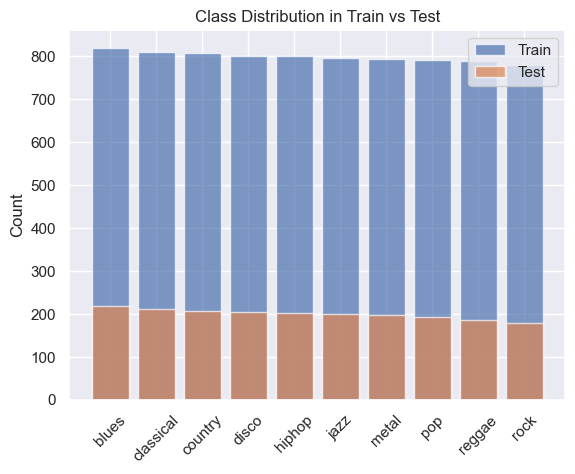

In [13]:
# Define genre labels
# - We define the list of genre labels that correspond to the target variable classes
genres = ["blues", "classical", "country", "disco", "hiphop", 
          "jazz", "metal", "pop", "reggae", "rock"]

# Count instances per class in the training set
# - This helps us understand the class distribution in the training data
train_class_counts = pd.Series(y2_train).value_counts()

# Count instances per class in the testing set
# - This helps us understand the class distribution in the testing data
test_class_counts = pd.Series(y2_test).value_counts()

# Plot class distribution
# - Visualize the class distribution in both the training and testing sets to ensure the split is balanced
plt.bar(genres, train_class_counts, label="Train", alpha=0.7)
plt.bar(genres, test_class_counts, label="Test", alpha=0.7)
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.title("Class Distribution in Train vs Test")
plt.legend()
plt.show()

### 3.4 Model Training

Model Architecture and Training:

- Model architecture: We define a deep neural network model with several dense layers (input, hidden, and output layers). The layers use ReLU activation with L2 regularization and batch normalization for stable learning.
- Model compilation: The model is compiled with the Adam optimizer, sparse categorical cross-entropy loss, and accuracy as the evaluation metric.
- Model training: We train the model for 20 epochs with a batch size of 16, using both training and validation data to monitor the model’s learning progress.

In [14]:
# Define the model architecture
# - We are using a Sequential model with dense layers and batch normalization
Model2 = models.Sequential([
    # Input layer
    # - First dense layer with ReLU activation and L2 regularization
    # - Batch normalization helps to stabilize and speed up the training process
    keras.layers.Dense(1024, activation='relu', input_shape=(X2_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),  # Normalize activations to improve model convergence

    # Hidden layers
    # - Second dense layer with ReLU activation and L2 regularization
    # - Batch normalization to maintain the stability of the network
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),  # Normalize activations

    # - Third dense layer with ReLU activation and L2 regularization
    # - Batch normalization applied to ensure stable learning
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001)),
    keras.layers.BatchNormalization(),  # Normalize activations

    # Output layer
    # - The final dense layer with 10 output units (corresponding to the 10 genres) and softmax activation for classification
    keras.layers.Dense(10, activation='softmax')  # Output 10 possible classes (genres)
])

# Compile the model using the Adam optimizer
# - Adam optimizer is selected with a learning rate of 0.0001 for stable training
# - We use sparse categorical cross-entropy loss function for multi-class classification tasks
# - Accuracy is used as the metric to evaluate the model's performance
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)

Model2.compile(optimizer=optimiser,
               loss=tf.keras.losses.sparse_categorical_crossentropy,
               metrics=['accuracy'])

# Train the model
# - The model is trained for 20 epochs with a batch size of 16
# - We use the training set (X2_train, y2_train) and validate the model using the test set (X2_test, y2_test)
# - The verbose argument is set to 1 to show progress during training
History2 = Model2.fit(X2_train,
                      y2_train,
                      validation_data=(X2_test, y2_test),
                      epochs=20,
                      batch_size=16,
                      verbose=1)

Epoch 1/20
500/500 [==============================] - 6s 7ms/step - loss: 1.3117 - accuracy: 0.5980 - val_loss: 0.8125 - val_accuracy: 0.7743
Epoch 2/20
500/500 [==============================] - 3s 6ms/step - loss: 0.7935 - accuracy: 0.7693 - val_loss: 0.6501 - val_accuracy: 0.8198
Epoch 3/20
500/500 [==============================] - 3s 6ms/step - loss: 0.6314 - accuracy: 0.8280 - val_loss: 0.5537 - val_accuracy: 0.8549
Epoch 4/20
500/500 [==============================] - 3s 6ms/step - loss: 0.5283 - accuracy: 0.8635 - val_loss: 0.4854 - val_accuracy: 0.8769
Epoch 5/20
500/500 [==============================] - 3s 6ms/step - loss: 0.4553 - accuracy: 0.8918 - val_loss: 0.4559 - val_accuracy: 0.8809
Epoch 6/20
500/500 [==============================] - 3s 6ms/step - loss: 0.3911 - accuracy: 0.9135 - val_loss: 0.4469 - val_accuracy: 0.8979
Epoch 7/20
500/500 [==============================] - 3s 6ms/step - loss: 0.3478 - accuracy: 0.9301 - val_loss: 0.4209 - val_accuracy: 0.9059
Epoch 

# 4. Evaluation and Comparison of Two Models

This code compares and evaluates the performance of two classification models on a multi-class music genre classification task. By analyzing both models, we gain insights into how each model works and what differences exist between them, helping us better understand their strengths and weaknesses. Here’s a brief overview:

### **1. Model Prediction and Evaluation**
- **Predictions & Probabilities**: Generates predictions and probabilities for each genre.
- **Accuracy Calculation**: Computes the model’s accuracy on the test dataset.
- **Classification Report**: Displays precision, recall, F1-score, and accuracy for each genre.

### **2. Misclassification Analysis**
- **Misclassification Summary**: Identifies genres with the most misclassifications.
- **Misclassification Breakdown**: Breaks down where genres are misclassified, showing confusion between classes.

### **3. Model Visualization**
- **Precision-Recall Curve**: Visualizes precision vs recall for each genre.
- **Training History Visualization**: Plots accuracy and loss over epochs to check for overfitting.
- **Overfitting Check**: Compares training and validation loss to identify overfitting.

### **4. Feature Space Visualization**
- **T-SNE Visualization**: Reduces test data to 2D space for visual inspection of genre separation.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_recall_curve
from sklearn.manifold import TSNE

# Define genre labels for classification report
genres = ["blues", "classical", "country", "disco", "hiphop", 
          "jazz", "metal", "pop", "reggae", "rock"]


#  1. Function to get predictions and probabilities from a model
def get_predictions(model, X_test):
    """
    ## Purpose:
    - This function generates the predictions and the probability distributions for each class.

    ## Steps:
    - The model predicts probabilities for each class (10 genres in this case).
    - The predicted class is chosen by selecting the class with the highest probability.

    ## Inputs:
    - model: The trained model that will be used to make predictions.
    - X_test: The test data used to get predictions.

    ## Outputs:
    - preds: The predicted class labels (argmax of the probabilities).
    - pred_probs: The probabilities for each genre (class).
    """
    pred_probs = model.predict(X_test)
    preds = np.argmax(pred_probs, axis=1)
    return preds, pred_probs


#  2. Function to compute accuracy of a model
def calculate_accuracy(y_test, preds, model_name="Model"):
    """
    ## Purpose:
    - This function calculates and prints the accuracy of the model on the test dataset.

    ## Steps:
    - It compares the predicted labels with the true labels (y_test) and computes the accuracy score.
    
    ## Inputs:
    - y_test: True labels of the test set.
    - preds: Predicted labels from the model.
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - test_accuracy: The calculated accuracy score.
    """
    test_accuracy = accuracy_score(y_test, preds)
    print(f"\n{model_name} - Test Accuracy: {test_accuracy:.4f}")
    return test_accuracy


#  3. Function to print a detailed classification report
def print_classification_report(y_test, preds, model_name="Model"):
    """
    ## Purpose:
    - This function generates and prints a detailed classification report with precision, recall, and F1-score for each genre.

    ## Steps:
    - The function calls the classification_report function to get performance metrics for each genre.
    - It prints out the overall accuracy, macro average, and weighted average scores.
    - The precision, recall, and F1-score are displayed for each genre.

    ## Inputs:
    - y_test: True labels of the test set.
    - preds: Predicted labels from the model.
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - The function prints the classification report.
    """
    report = classification_report(y_test, preds, target_names=genres, digits=2, output_dict=True)
    
    accuracy = report["accuracy"]
    macro_avg = report["macro avg"]
    weighted_avg = report["weighted avg"]

    print(f"\n{'='*10} {model_name} - Classification Report {'='*10}\n")
    
    print(f"Overall Accuracy: {accuracy:.2%}")
    print(f"Macro Avg  - Precision: {macro_avg['precision']:.2f}, Recall: {macro_avg['recall']:.2f}, F1-score: {macro_avg['f1-score']:.2f}")
    print(f"Weighted Avg  - Precision: {weighted_avg['precision']:.2f}, Recall: {weighted_avg['recall']:.2f}, F1-score: {weighted_avg['f1-score']:.2f}\n")
    
    print(f"{'Genre':<12} {'Precision':<10} {'Recall':<10} {'F1-score':<10} {'Support':<10}")
    print("-" * 50)
    for genre in genres:
        g = report[genre]
        print(f"{genre:<12} {g['precision']:.2f}      {g['recall']:.2f}      {g['f1-score']:.2f}      {int(g['support']):<10}")

    print("=" * 45)

    
#  4. Function to analyze misclassification
def analyze_misclassification(conf_matrix, model_name="Model"):
    """
    ## Purpose:
    - This function identifies and analyzes the misclassified samples by genre.
    - It provides a summary of misclassifications and highlights the most misclassified genres.

    ## Steps:
    - The misclassified counts for each genre are computed from the confusion matrix.
    - A summary of misclassifications per genre is printed.
    - It identifies the genres that were most frequently misclassified.

    ## Inputs:
    - conf_matrix: The confusion matrix that shows the predicted vs true labels.
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - The function prints misclassification summaries.
    """
    misclassified_counts = conf_matrix.sum(axis=1) - np.diag(conf_matrix)  # Misclassified samples per genre
    total_samples = conf_matrix.sum(axis=1)  # Total test samples per genre

    misclassification_df = pd.DataFrame({
        "Genre": genres,
        "Total Samples": total_samples,
        "Correct Predictions": np.diag(conf_matrix),
        "Misclassified": misclassified_counts
    })

    print(f"\n=== {model_name} - Misclassification Summary ===")
    print(misclassification_df)

    # Most misclassified genres
    misclass_per_class = misclassification_df.sort_values(by="Misclassified", ascending=False)
    print(f"\n=== {model_name} - Most Misclassified Genres ===")
    print(misclass_per_class.head(5))
    
    
#  5. Function to analyze misclassification breakdown
def misclassification_breakdown(conf_matrix, model_name="Model"):
    """
    ## Purpose:
    - This function provides a detailed breakdown of misclassifications for each genre.
    - It shows which genres are misclassified as other genres.

    ## Steps:
    - For each genre, misclassifications are tallied and displayed, highlighting which other genres were predicted incorrectly.

    ## Inputs:
    - conf_matrix: The confusion matrix that shows the predicted vs true labels.
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - The function prints a detailed breakdown of misclassifications.
    """
    print(f"\n{'='*15} {model_name} - Misclassification Breakdown {'='*15}\n")

    for i, genre in enumerate(genres):
        misclassified_genres = conf_matrix[i]  # Row corresponding to the genre
        misclassified_genres[i] = 0  # Remove correctly classified count

        total_misclassified = misclassified_genres.sum()
        if total_misclassified > 0:
            print(f"📌 **{genre.upper()} misclassified as:**")
            misclassified_df = pd.DataFrame({"Genre": genres, "Misclassified Count": misclassified_genres})
            misclassified_df = misclassified_df[misclassified_df["Misclassified Count"] > 0]
            
            for _, row in misclassified_df.iterrows():
                print(f"  - {row['Genre']} ({int(row['Misclassified Count'])})")
            
            print("-" * 40)

            
#  6. Precision-Recall Curve 
def plot_precision_recall_curve(y_test, pred_probs, model_name="Model"):
    """
    ## Purpose:
    - This function plots the precision-recall curve for each genre.

    ## Steps:
    - For each genre, the precision and recall are computed using the precision_recall_curve function.
    - The curves are plotted to evaluate how well the model performs for each genre.

    ## Inputs:
    - y_test: True labels of the test set.
    - pred_probs: The predicted probabilities for each class.
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - A plot of precision vs recall for each genre.
    """
    plt.figure(figsize=(8, 6))
    for i, genre in enumerate(genres):
        precision, recall, _ = precision_recall_curve((y_test == i).astype(int), pred_probs[:, i])
        plt.plot(recall, precision, label=genre)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{model_name} - Precision-Recall Curve")
    plt.legend()
    plt.show()

    
#  7. Overfitting Check 
def plot_overfitting_check(history, model_name="Model"):
    """
    ## Purpose:
    - This function plots the training and validation loss to visually check for overfitting.

    ## Steps:
    - The training loss and validation loss for each epoch are plotted to see if the model is overfitting.
    - If the validation loss increases while the training loss decreases, it may indicate overfitting.

    ## Inputs:
    - history: The training history of the model (obtained from the 'fit' method).
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - A plot showing training and validation loss over epochs.
    """
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Overfitting Check")
    plt.legend()
    plt.show()

    
#  8. Feature Space Visualization using T-SNE 
def plot_tsne(X_test, y_test, model_name="Model"):
    """
    ## Purpose:
    - This function uses T-SNE to reduce the dimensionality of the feature space and visualize the data.

    ## Steps:
    - T-SNE is applied to the test data to reduce it to 2 dimensions for visualization.
    - The points are plotted in a 2D space with different colors for each genre.

    ## Inputs:
    - X_test: The feature vectors of the test set.
    - y_test: The true labels of the test set.
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - A 2D scatter plot of the feature space, with points colored according to their genre.
    """
    X_embedded = TSNE(n_components=2).fit_transform(X_test)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_test, cmap="jet", alpha=0.5)
    plt.colorbar()
    plt.title(f"{model_name} - T-SNE Feature Space")
    plt.show()

    
#  9. Training History Visualization 
def plot_training_history(history, model_name="Model"):
    """
    ## Purpose:
    - This function visualizes the training history by plotting accuracy and loss over epochs.

    ## Steps:
    - It plots two graphs: one for accuracy and one for loss (both for training and validation).
    - This helps to evaluate how well the model is performing during training and if it is overfitting.

    ## Inputs:
    - history: The training history of the model (obtained from the 'fit' method).
    - model_name: Name of the model (default is "Model").
    
    ## Outputs:
    - Two plots: One for accuracy and one for loss.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Training vs Validation Accuracy")
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Training vs Validation Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

    
#  10. Confusion Matrix Plot 
def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """
    ## Purpose:
    - This function visualizes the confusion matrix comparing predicted vs. true labels.

    ## Steps:
    - Computes the confusion matrix and displays it with genre labels and annotations.

    ## Inputs:
    - y_true: True labels.
    - y_pred: Predicted labels.
    - model_name: Model name for the plot title.
    
    ## Outputs:
    - Displays the confusion matrix plot.
    - Returns the confusion matrix.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 5))
    plt.imshow(conf_matrix, interpolation='nearest', cmap='coolwarm')
    plt.colorbar()

    # Add labels and ticks
    tick_marks = np.arange(len(genres))
    plt.xticks(tick_marks, genres, rotation=45, ha="right")
    plt.yticks(tick_marks, genres)

    # Annotate cells
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='white' if conf_matrix[i, j] > conf_matrix.max() / 2 else 'black')

    # Add 1px edge around the entire matrix
    ax = plt.gca()  # Get current axes
    for spine in ax.spines.values():
        spine.set_edgecolor('black')  # Set edge color
        spine.set_linewidth(1)  # Set edge thickness to 1px        
        
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

    return conf_matrix

## 4.1 Plot training history for both models

Visualize accuracy and loss for Model 1 and Model 2 over epochs.

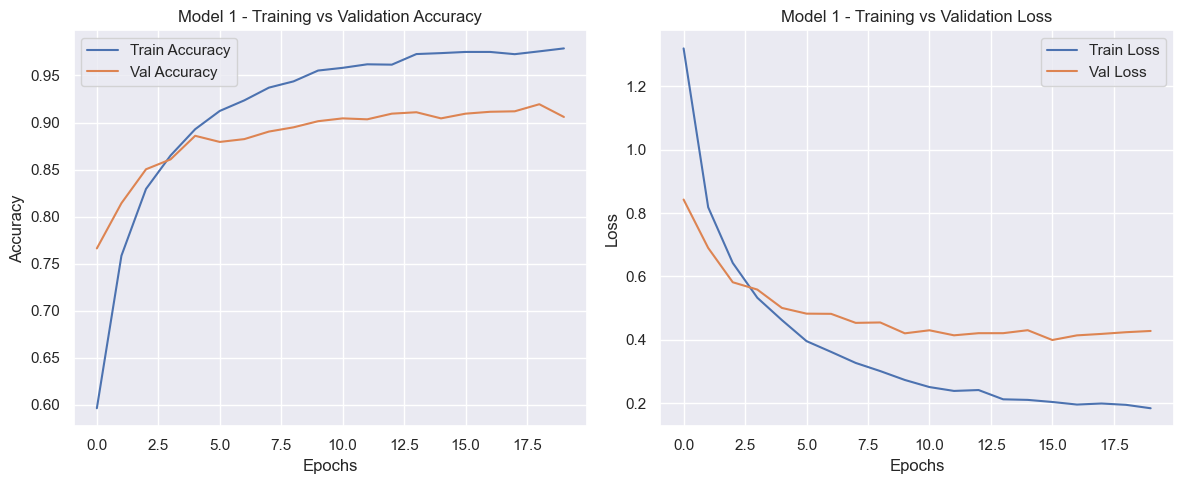

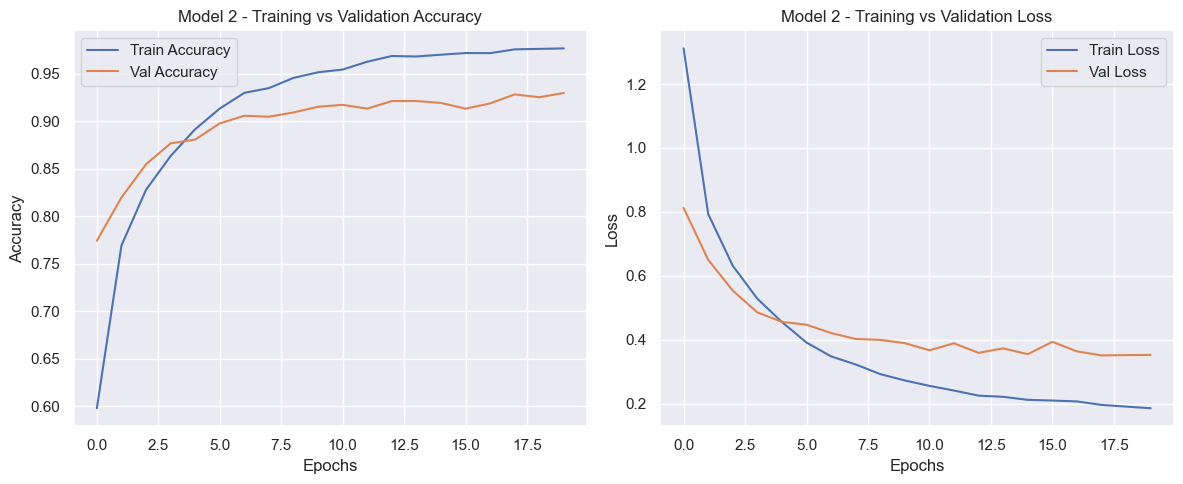

In [16]:
plot_training_history(History1, model_name="Model 1")
plot_training_history(History2, model_name="Model 2")

## 4.2 Get predictions for both models

Obtain predicted labels and probabilities for both models using test data.

In [17]:
preds1, pred_probs1 = get_predictions(Model1, X1_test)
preds2, pred_probs2 = get_predictions(Model2, X2_test)

63/63 [==============================] - 0s 2ms/step


## 4.3 Compute accuracy for both models

Calculate and print the accuracy of Model 1 and Model 2 on the test set.

In [18]:
calculate_accuracy(y1_test, preds1, model_name="Model 1")
calculate_accuracy(y2_test, preds2, model_name="Model 2")


Model 1 - Test Accuracy: 0.9059

Model 2 - Test Accuracy: 0.9299


0.92992992992993

## 4.4 Plot confusion matrix for both models

Generate and display confusion matrices for both models' predictions.

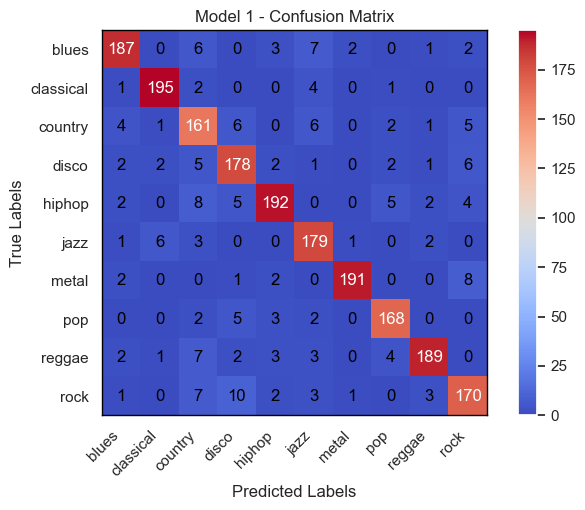

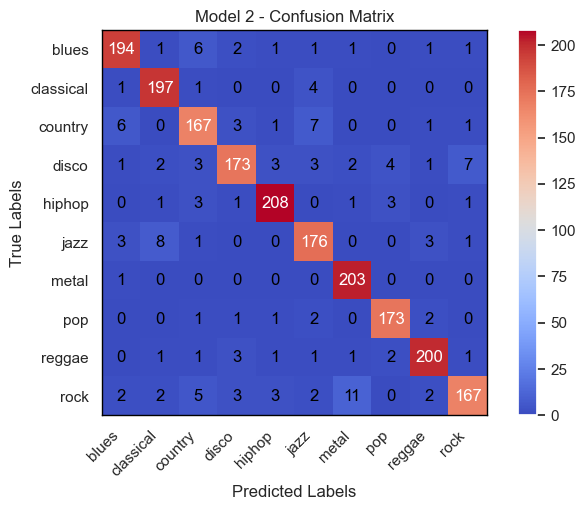

In [19]:
conf_matrix1 = plot_confusion_matrix(y1_test, preds1, model_name="Model 1")
conf_matrix2 = plot_confusion_matrix(y2_test, preds2, model_name="Model 2")

## 4.5 Print classification reports for both models

Display precision, recall, F1-score, and accuracy for Model 1 and Model 2.

In [20]:
print_classification_report(y1_test, preds1, model_name="Model 1")
print_classification_report(y2_test, preds2, model_name="Model 2")


========== Model 1 - Classification Report ==========

Overall Accuracy: 90.59%
Macro Avg  - Precision: 0.91, Recall: 0.91, F1-score: 0.91
Weighted Avg  - Precision: 0.91, Recall: 0.91, F1-score: 0.91

Genre        Precision  Recall     F1-score   Support   
--------------------------------------------------
blues        0.93      0.90      0.91      208       
classical    0.95      0.96      0.96      203       
country      0.80      0.87      0.83      186       
disco        0.86      0.89      0.88      199       
hiphop       0.93      0.88      0.90      218       
jazz         0.87      0.93      0.90      192       
metal        0.98      0.94      0.96      204       
pop          0.92      0.93      0.93      180       
reggae       0.95      0.90      0.92      211       
rock         0.87      0.86      0.87      197       

========== Model 2 - Classification Report ==========

Overall Accuracy: 92.99%
Macro Avg  - Precision: 0.93, Recall: 0.93, F1-score: 0.93
Weighted 

## 4.6 Analyze misclassification for both models

Summarize and compare misclassifications for Model 1 and Model 2.

In [21]:
analyze_misclassification(conf_matrix1, model_name="Model 1")

print("-"*100)

analyze_misclassification(conf_matrix2, model_name="Model 2")


=== Model 1 - Misclassification Summary ===
       Genre  Total Samples  Correct Predictions  Misclassified
0      blues            208                  187             21
1  classical            203                  195              8
2    country            186                  161             25
3      disco            199                  178             21
4     hiphop            218                  192             26
5       jazz            192                  179             13
6      metal            204                  191             13
7        pop            180                  168             12
8     reggae            211                  189             22
9       rock            197                  170             27

=== Model 1 - Most Misclassified Genres ===
     Genre  Total Samples  Correct Predictions  Misclassified
9     rock            197                  170             27
4   hiphop            218                  192             26
2  country          

## 4.7 Print breakdown of misclassifications for both models

Show where genres are misclassified and which genres are confused with others.

In [22]:
misclassification_breakdown(conf_matrix1, model_name="Model 1")

print("-" * 100)

misclassification_breakdown(conf_matrix2, model_name="Model 2")


=============== Model 1 - Misclassification Breakdown ===============

📌 **BLUES misclassified as:**
  - country (6)
  - hiphop (3)
  - jazz (7)
  - metal (2)
  - reggae (1)
  - rock (2)
----------------------------------------
📌 **CLASSICAL misclassified as:**
  - blues (1)
  - country (2)
  - jazz (4)
  - pop (1)
----------------------------------------
📌 **COUNTRY misclassified as:**
  - blues (4)
  - classical (1)
  - disco (6)
  - jazz (6)
  - pop (2)
  - reggae (1)
  - rock (5)
----------------------------------------
📌 **DISCO misclassified as:**
  - blues (2)
  - classical (2)
  - country (5)
  - hiphop (2)
  - jazz (1)
  - pop (2)
  - reggae (1)
  - rock (6)
----------------------------------------
📌 **HIPHOP misclassified as:**
  - blues (2)
  - country (8)
  - disco (5)
  - pop (5)
  - reggae (2)
  - rock (4)
----------------------------------------
📌 **JAZZ misclassified as:**
  - blues (1)
  - classical (6)
  - country (3)
  - metal (1)
  - reggae (2)
--------------------

## 4.8 Plot precision-recall curves for both models

Visualize precision and recall for each genre across different thresholds for both models.

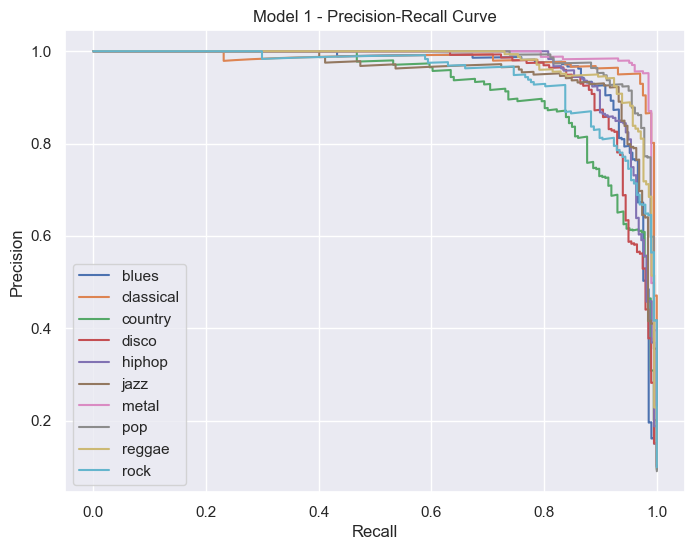

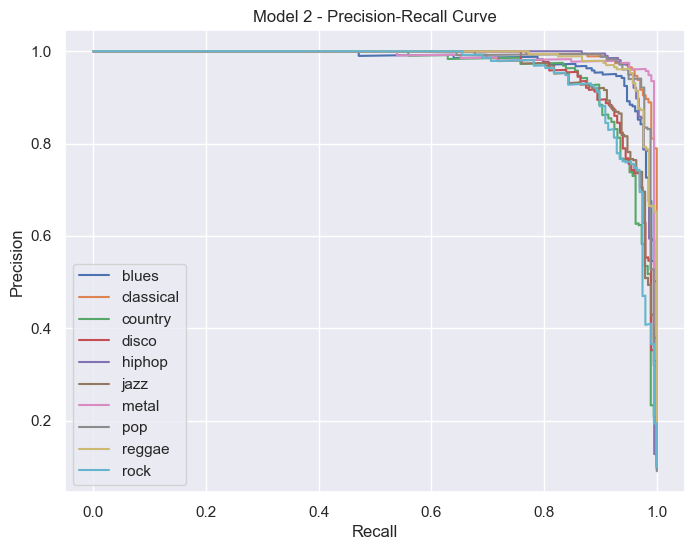

In [23]:
plot_precision_recall_curve(y1_test, pred_probs1, model_name="Model 1")
plot_precision_recall_curve(y2_test, pred_probs2, model_name="Model 2")

## 4.9 Plot overfitting check for both models

Compare training and validation loss to detect overfitting in Model 1 and Model 2.

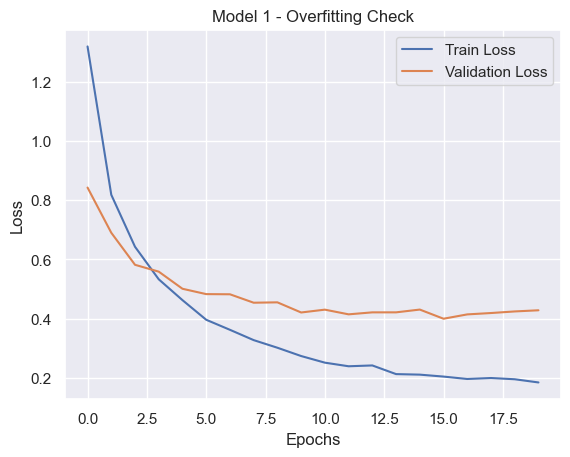

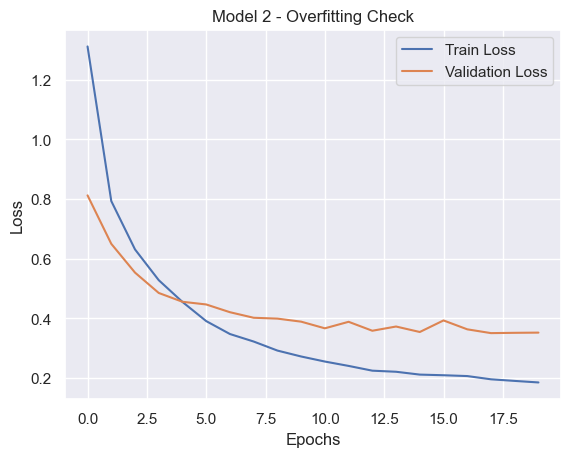

In [24]:
plot_overfitting_check(History1, model_name="Model 1")
plot_overfitting_check(History2, model_name="Model 2")

## 4.10 Plot t-SNE for both models

Visualize test data in 2D space using t-SNE for both models to inspect feature separation.

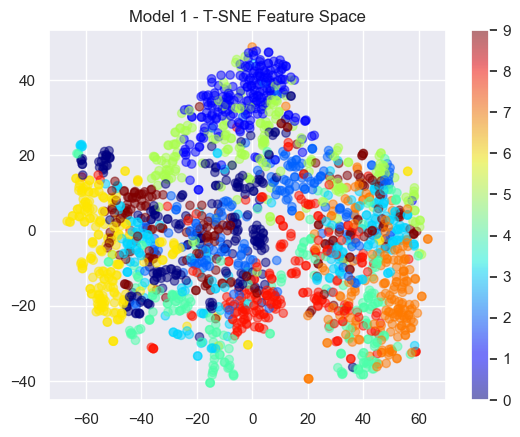

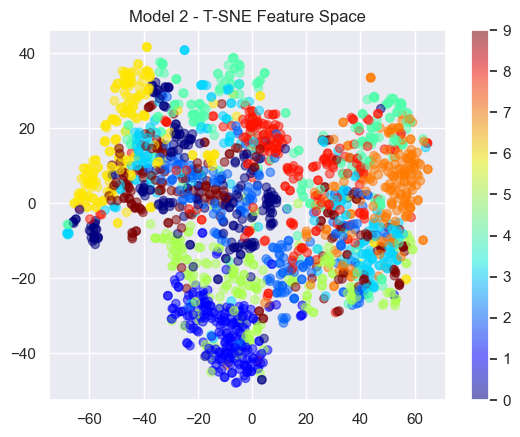

In [25]:
plot_tsne(X1_test, y1_test, model_name="Model 1")
plot_tsne(X2_test, y2_test, model_name="Model 2")